# Histogram Matching
In this notebook, we want to transform one (target) distribution to look like another (reference) distribution. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# Define some distributions
d = [
    np.random.normal(loc=8, scale=1, size=10000),
    np.random.normal(loc=5, scale=2, size=10000)
    # np.random.normal(loc=0, scale=4, size=10000)
    ]

# global mins and maxes
g = np.concatenate(d)
print(g.min(), g.max())

# bins
bin_range = [g.min(), g.max()]
bin_num = int((g.max()-g.min())/.5)

# plot colors
line_colors = ["xkcd:red", "xkcd:blue", "xkcd:green"]
pdf_colors = [(1, 0, 0, .5), (0, 0, 1, .5), (0, 1, 0, .4)]

line_colors = line_colors[:len(d)]
pdf_colors = pdf_colors[:len(d)]

-2.612542591285684 12.848201221762652


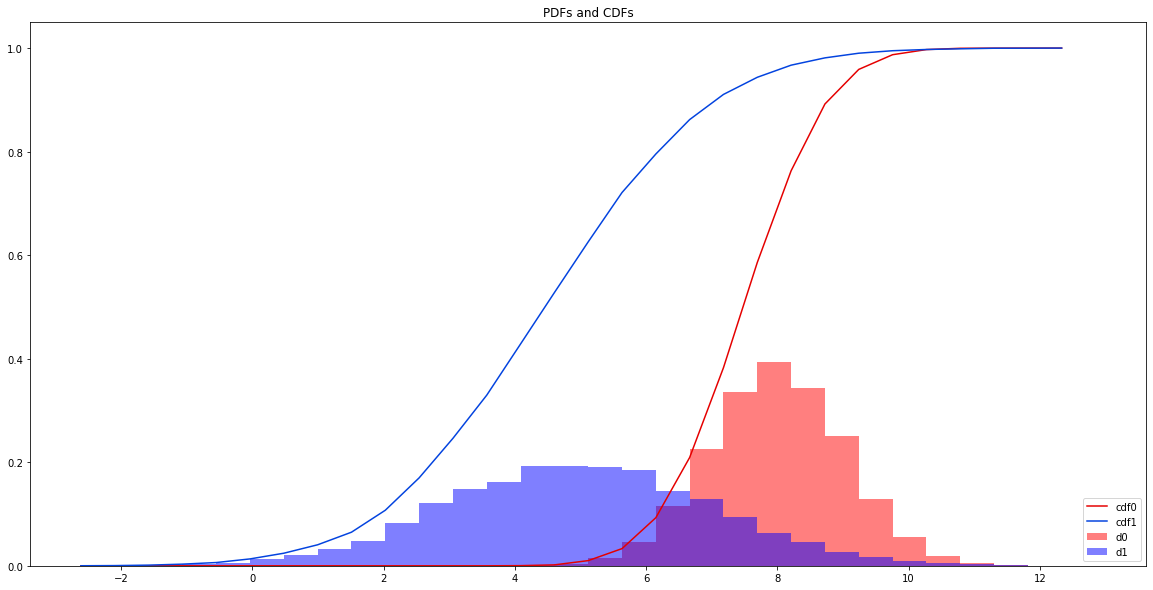

In [24]:
# Show histograms with CDF
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(20,10))
histograms = []
for i, data in enumerate(zip(d, pdf_colors, line_colors)):
    d_i, pdf_color, line_color = data
    
    # plot pdf
    hist, bin_edges, _ = ax.hist(d_i, bins=bin_num, range=bin_range, density=True, label=f"d{i}", fc=pdf_color)
    hist = hist/sum(hist)  # use pdf
    histograms.append((hist, bin_edges))
    
    # calculate cdf 
    cdf = np.cumsum(hist)  

    # plot cdf
    width = np.diff(bin_edges)
    ax.plot((np.arange(len(cdf))*width)+bin_edges[0], cdf, line_color, label=f"cdf{i}")
    

ax.legend(loc='lower right')
ax.set_title("PDFs and CDFs")
plt.show()


We can compute the histogram matching transformation by utilizing the CDFs of the target and reference distribution. 

![alt text](image.png "Histogram Matching")

To match the histograms, we first need to find x values $x_i$ and $x_j$ from CDFs G and H such that $G(x_i) = H(x_j)$. We then want to define a mapping from one CDF to the other for any x.

In [25]:
def histogram_match(target, reference):
    # # # 
    #
    # Params: 
    #    target: distribution as np array
    #    reference: Pdistribution as np array
    #
    # Output: 
    #    "matched" target distribution to reference distribution
    #
    # # #
    
    # global mins and maxes
    g = np.concatenate((target, reference))

    # bins
    bin_range = [g.min(), g.max()]
    bin_num = int((g.max()-g.min())/.5)
    
    # Convert distributions to histograms
    target_hist, target_be = np.histogram(target, bins=bin_num, range=bin_range, density=True)
    reference_hist, reference_be = np.histogram(reference, bins=bin_num, range=bin_range, density=True)
    
    # PDF
    target_hist = target_hist/sum(target_hist)
    reference_hist = reference_hist/sum(reference_hist)
    
    # choose some arbitrary y values (y range: [0, 1])
    y_vals = np.random.uniform(size=10000)

    # sort these as monotonically increasing
    y_vals.sort()
    
    # interpolate x value pairs from the CDFs
    x_reference = np.interp(
        y_vals,
        np.hstack((np.zeros(1), np.cumsum(reference_hist))),
        reference_be)
    
    x_target = np.interp(
        y_vals,
        np.hstack((np.zeros(1), np.cumsum(target_hist))),
        target_be)
    
    # We now have three vectors denoting y-x0-x1 groups. We want to create a mapping
    # that defines the relationship for x0 -> x1 for any x0. 
    m_vals = np.interp(
        np.linspace(g.min(), g.max(), 10000),
        x_target,
        x_reference)
    
    # Interpolate values over the combined distributions
    x = np.arange(g.min(), g.max(), (g.max()-g.min())/10000)

    m = np.interp(target, x, m_vals)
    
    return m


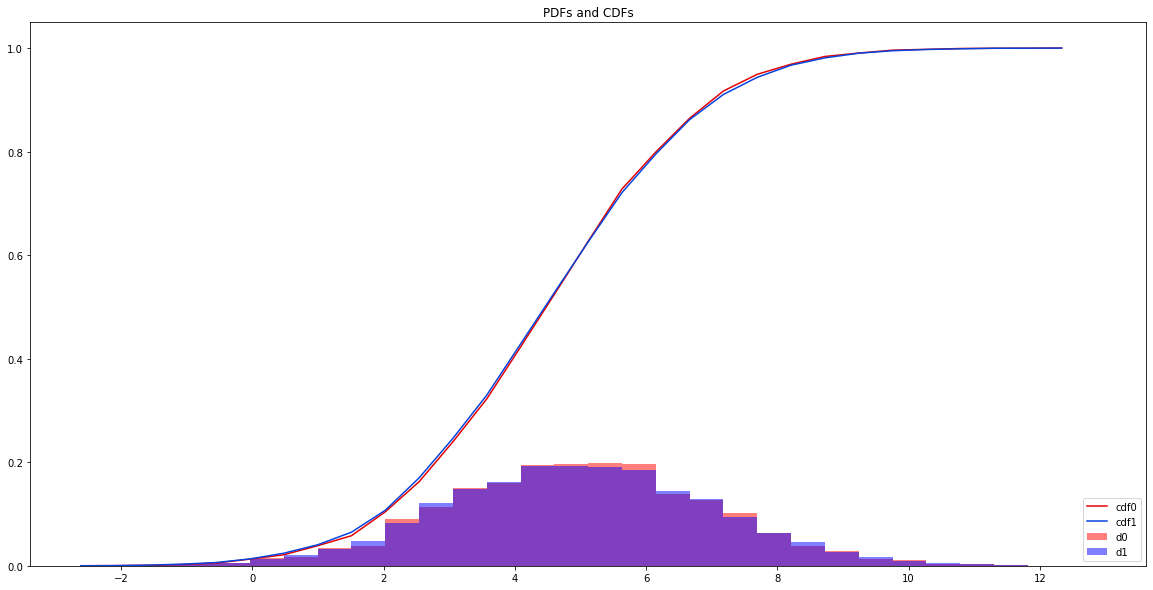

In [26]:
# Put all of this together

fig, (ax) = plt.subplots(1, figsize=(20,10))

m = histogram_match(d[0], d[1])

# Overwrite the target distribution with the matched distribution
d_new = (m, d[1])

for i, data in enumerate(zip(d_new, pdf_colors, line_colors)):
    d_i, pdf_color, line_color = data
    
    # plot pdf
    hist, bin_edges, _ = ax.hist(d_i, bins=bin_num, range=bin_range, density=True, label=f"d{i}", fc=pdf_color)
    hist = hist/sum(hist)  # use pdf
    
    # calculate cdf 
    cdf = np.cumsum(hist)  

    # plot cdf
    width = np.diff(bin_edges)
    ax.plot((np.arange(len(cdf))*width)+bin_edges[0], cdf, line_color, label=f"cdf{i}")
    
ax.set_title("PDFs and CDFs")
ax.legend(loc='lower right')

plt.show()
